# Preprocess the Model for Ratio Reconstruction

### TO DO:
Have some simple tests that check data when loading. Leverage existing reading tools but add project specific checks later
* station data
* [x] ensemble mean
* [x] mask?
* Have option to use PyKrige or R for reconstruction?

In [28]:
from climpyrical.data import read_data, gen_dataset, interpolate_dataset
from climpyrical.gridding import regrid_ensemble, extend_north

import xarray as xr
import numpy as np
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator

import matplotlib.pyplot as plt
import matplotlib

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 28}

matplotlib.rc('font', **font)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# Path to the ensemble mean

# PATH_MEAN = '/home/nannau/nrc_data/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
# PATH_MEAN = '/home/nannau/nrc_data/hdd_CanRCM4-LE_ens35_1951-2016_ann_ensmean.nc'
PATH_MEAN = '/home/nannau/nrc_data/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'

# dv = 'Rain-RL50'
# dv='heating_degree_days_per_time_period'
dv ='snw'

ds_mean = read_data(PATH_MEAN)

## Interpolate the model

In [30]:
# Create coordinate grids
rlon, rlat = np.meshgrid(ds_mean.rlon, ds_mean.rlat)

# Create array of mean
mean = ds_mean[dv].values

Load the Surface to Land Fraction Mask `sftlf`

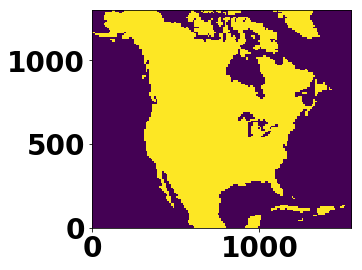

In [31]:
mask = read_data('/home/nannau/nrc_data/land_mask_CanRCM4_sftlf.nc')

# regrid dataset to target resolution
mask = regrid_ensemble(mask, 'sftlf', 10, copy=True)

# convert to boolean mask
mask = mask['sftlf'] >= 1.0

# Show mask
plt.imshow(mask, origin='lower')

Use regridded mask to reference the new coordinates on the map

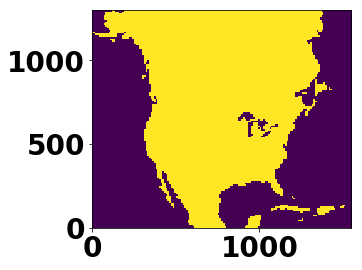

In [32]:
temp_field = np.ones(mask.shape)*np.nan

ds10_cp = regrid_ensemble(ds_mean, dv, 10, copy=True, keys=['rlat', 'rlon'])
nanmask10 = ~np.isnan(ds10_cp[dv]).values

interp_mask = np.logical_or(nanmask10, mask)

plt.imshow(interp_mask, origin='lower')

In [33]:
xx, yy = np.meshgrid(np.linspace(0, 50, 50), np.linspace(-25, 25, 50))
points = np.stack([xx.flatten(), yy.flatten()]).T
ones = np.ones(xx.shape)
xxn, yyn = np.meshgrid(np.linspace(0, 50, 100), np.linspace(-25, 25, 100))

target_points = np.stack([xxn.flatten(), yyn.flatten()]).T

interpolate_dataset(points, ones.flatten(), target_points, 'linear')

array([1., 1., 1., ..., 1., 1., 1.])

In [43]:
from nptyping import NDArray
from typing import Any
ndim = np.ndim(ds_mean[dv].values)
nds = regrid_ensemble(ds_mean, dv, 3,  ["rlat", "rlon"], True)
assert isinstance(nds[dv].values, NDArray[(Any,) * ndim, Any])
# nds[dv].values.dtype

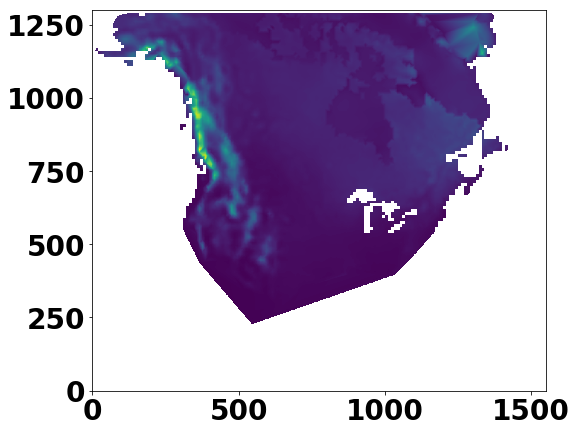

In [29]:
# find NaN values in ensemble mean
nanmask = ~np.isnan(mean)
# create interpolator for non NaN values

# new coordinates to interpolate to
nrlon, nrlat = np.meshgrid(mask.rlon.values, mask.rlat.values)

points = np.stack([rlon[nanmask], rlat[nanmask]]).T
target_points = np.stack([nrlon[interp_mask], nrlat[interp_mask]]).T

temp_field[interp_mask] = interpolate_dataset(points, mean.values[nanmask], target_points, 'linear')
ds_mean10 = gen_dataset(dv, temp_field, mask.rlon, mask.rlat)

plt.figure(figsize=(10, 7))
plt.imshow(ds_mean10[dv], origin='lower')

Extend to the north for non-modelled region

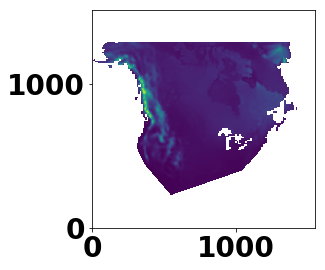

In [14]:
mean10_ext = extend_north(ds_mean10, dv, 210, fill_val=np.nan)
nrlon, nrlat = np.meshgrid(mean10_ext.rlon.values, mean10_ext.rlat.values)

plt.imshow(mean10_ext[dv], origin='lower')

Load final refined mask. If not accessible, or desire difference shapefile, follow `mask.ipynb`

(1510, 1550)


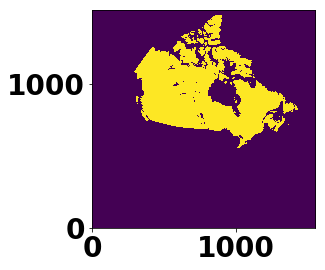

In [15]:
with read_data('./data/processed/canada_mask_rp.nc') as ds:
    print(ds['mask'].shape)
    rmask = ds['mask'].values
    
plt.imshow(rmask, origin='lower')

In [16]:
np.all(ds.to_array().isnull()).values

array(False)

Find inconsistent areas between the refined mask and the model by comparing model values with refined mask values

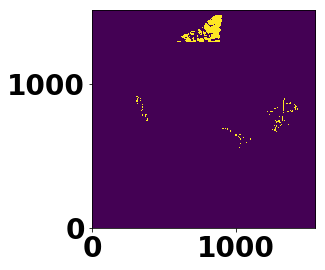

In [17]:
nanmask10 = ~np.isnan(mean10_ext[dv])
rmask_or = ~np.logical_or(~rmask, nanmask10)

plt.imshow(rmask_or, origin='lower')

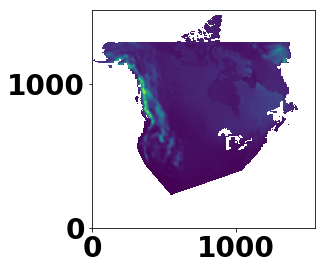

In [18]:
# Fill inconsistent points using closest neighbour.
# Not that the northern section will be filled later on

temp_field = mean10_ext[dv].values

points = np.stack([nrlon[nanmask10], nrlat[nanmask10]]).T
f = NearestNDInterpolator(points, mean10_ext[dv].values[nanmask10])
temp_field[rmask_or] = f(np.stack([nrlon[rmask_or], nrlat[rmask_or]]).T)

mean10_ext_f = xr.Dataset(
    {dv: (["rlat", "rlon"], temp_field)},
    coords={"rlon": ("rlon", mean10_ext.rlon), "rlat": ("rlat", mean10_ext.rlat)},
)

plt.imshow(mean10_ext_f[dv], origin='lower')

In [10]:
np.any(mean10_ext_f[dv] < 0)

<xarray.DataArray 'snw' ()>
array(False)

In [11]:
# Check all inconsistencies are filled
assert ~np.any(~np.logical_or(~rmask, ~np.isnan(mean10_ext_f[dv]))).values

In [12]:
# with open('./data/processed/pre_processed.nc', 'wb') as d:
import os
if os.path.exists("./data/processed/pre_processed.nc"):
    os.remove("./data/processed/pre_processed.nc")

mean10_ext_f.to_netcdf('./data/processed/pre_processed.nc', 'w')